# MNIST softmax with `tf.data`

* Make a very simple networks which have just one layer. (No hidden layers)
* input pipeline: `tf.data`
* Eager execution

## Training Pseudo Code

```python
for epoch in max_epochs: # 1 epoch: 모든 데이터(N)를 한번 학습 시켰을 때
  for step in num_batches: # num_batches = int(data_size / batch_size)
    1. sampling mini-batches with batch_size
      1-1. data augmentation [if you need (actually always)]
    2. calculate the logits # logits = f(x)
    3. calculate the loss # loss = loss(logits, labels)
    4. calculate the gradient with respect to weights
    5. update weights
```

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os
import time
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import clear_output

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
from tensorflow.keras import layers
tf.enable_eager_execution()

sess_config = tf.ConfigProto(gpu_options=tf.GPUOptions(allow_growth=True))
os.environ["CUDA_VISIBLE_DEVICES"]="0"

### Import data

In [2]:
# Load training and eval data from tf.keras
(train_data, train_labels), (test_data, test_labels) = \
    tf.keras.datasets.mnist.load_data()

train_data = train_data / 255.
train_data = train_data.reshape(-1, 784)
train_data = train_data.astype(np.float32)
train_labels = train_labels.astype(np.int32)

test_data = test_data / 255.
test_data = test_data.reshape(-1, 784)
test_data = test_data.astype(np.float32)
test_labels = test_labels.astype(np.int32)

### Show the MNIST

label = 7


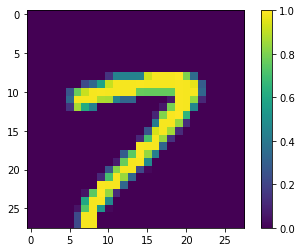

In [3]:
index = 123
print("label = {}".format(train_labels[index]))
plt.imshow(train_data[index].reshape(28, 28))
plt.colorbar()
#plt.gca().grid(False)
plt.show()

### Set up dataset with `tf.data`

#### input pipeline `tf.data.Dataset` and Transformation

In [4]:
tf.set_random_seed(219)
batch_size = 32
max_epochs = 1

# for train
train_dataset = tf.data.Dataset.from_tensor_slices((train_data, train_labels))
train_dataset = train_dataset.shuffle(buffer_size = 10000)
#train_dataset = train_dataset.repeat(count = max_epochs)
train_dataset = train_dataset.repeat()
train_dataset = train_dataset.batch(batch_size = batch_size)
print(train_dataset)

# for test
test_dataset = tf.data.Dataset.from_tensor_slices((test_data, test_labels))
test_dataset = test_dataset.batch(batch_size = len(test_data))
print(test_dataset)

<BatchDataset shapes: ((?, 784), (?,)), types: (tf.float32, tf.int32)>
<BatchDataset shapes: ((?, 784), (?,)), types: (tf.float32, tf.int32)>


### Create the model

* Use `tf.keras.layers`

In [5]:
model = tf.keras.Sequential([
# Adds a densely-connected layer with 64 units to the model:
#layers.Dense(64, activation='relu'),
# Add another:
#layers.Dense(64, activation='relu'),
# Add a softmax layer with 10 output units:
layers.Dense(10)])

In [6]:
# without training, just inference a model in eager execution:
for images, labels in train_dataset.take(1):
  print("Logits: ", model(images[0:1]).numpy())

Logits:  [[-0.17331201  0.5020913  -0.74303025  0.5237652  -0.36942014  0.08265399
   0.1998107   0.14496097 -0.32580706 -0.6672988 ]]


### Define a optimizer

In [7]:
# Train the model
optimizer = tf.train.GradientDescentOptimizer(0.5)
loss_history = []

### Train a model

In [8]:
total_steps = int( len(train_data) / batch_size * max_epochs)
for (step, (images, labels)) in enumerate(train_dataset.take(total_steps)): # just steps number (iterations), NOT epochs
  start_time = time.time()
  with tf.GradientTape() as tape:
    logits = model(images, training=True)
    loss_value = tf.losses.sparse_softmax_cross_entropy(labels, logits)

  loss_history.append(loss_value.numpy())
  grads = tape.gradient(loss_value, model.variables)
  optimizer.apply_gradients(zip(grads, model.variables),
                            global_step=tf.train.get_or_create_global_step())
  
  if step % 100 == 0:
      clear_output(wait=True)
      duration = time.time() - start_time
      examples_per_sec = batch_size / float(duration)
      epochs = batch_size * step / float(len(train_data))
      print("epochs: {:.2f}, step: {}, loss: {:g}, ({:.2f} examples/sec; {:.3f} sec/batch)".format(epochs, step, loss_value, examples_per_sec, duration))
    
print("training done!")

epochs: 0.96, step: 1800, loss: 0.292055, (10406.09 examples/sec; 0.003 sec/batch)
training done!


### Plot the loss funtion

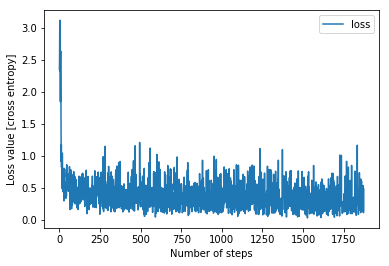

In [9]:
plt.plot(loss_history, label='loss')
plt.xlabel('Number of steps')
plt.ylabel('Loss value [cross entropy]')
plt.legend()
plt.show()

### Test trained model

* test accuracy: 0.9151 for 1 epochs
* test accuracy: 0.9162 for 10 epochs

In [10]:
accuracy = tf.contrib.eager.metrics.Accuracy()

for (step, (images, labels)) in enumerate(test_dataset.take(1)):
  logits = model(images, training=False)
  accuracy(labels=labels, predictions=tf.cast(tf.argmax(logits, 1), tf.int32))
  
print("test accuracy: {}".format(accuracy.result()))

test accuracy: 0.9151


### Plot test set

In [11]:
np.random.seed(219)

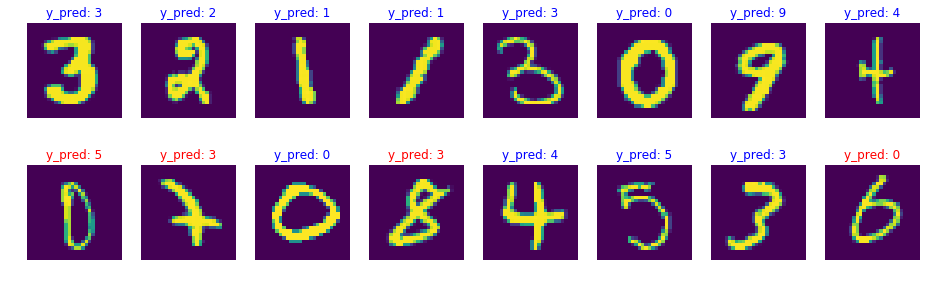

In [12]:
test_batch_size = 16
batch_index = np.random.choice(len(test_data), size=test_batch_size, replace=False)

batch_xs = test_data[batch_index]
batch_ys = test_labels[batch_index]
y_pred_ = model(batch_xs, training=False)

fig = plt.figure(figsize=(16, 10))
for i, (px, py) in enumerate(zip(batch_xs, y_pred_)):
  p = fig.add_subplot(4, 8, i+1)
  if np.argmax(py) == batch_ys[i]:
    p.set_title("y_pred: {}".format(np.argmax(py)), color='blue')
  else:
    p.set_title("y_pred: {}".format(np.argmax(py)), color='red')
  p.imshow(px.reshape(28, 28))
  p.axis('off')